In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint,EarlyStopping
import os
import matplotlib.pyplot as plt
from IPython.display import Image 

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [61]:
traindir = '/content/drive/My Drive/modak/train/'
validdir = '/content/drive/My Drive/modak/val/'
batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        traindir,  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 224x224
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        validdir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')

Found 2107 images belonging to 2 classes.
Found 232 images belonging to 2 classes.


In [62]:
backbone = VGG16(include_top=False, input_shape=(224, 224, 3))
for layer in backbone.layers:
  layer.trainable = False

model = Sequential()
model.add(backbone)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dense_17 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 257       
Total params: 21,203,521
Trainable params: 6,488,833
Non-trainable params: 14,714,688
__________________________________

In [0]:
checkpoint = ModelCheckpoint(filepath='modak_best_weights.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_acc', patience=3, verbose=1, mode='max',restore_best_weights=True)

In [64]:
epochs=20
history = model.fit_generator(train_generator,
                    epochs=epochs,
                    steps_per_epoch=2107 // batch_size,
                    validation_data=validation_generator,
                    validation_steps=232 // batch_size,
                    callbacks=[checkpoint,early_stopping],
                    verbose=1
                   )

Epoch 1/20
 5/65 [=>............................] - ETA: 1:08 - loss: 1.7461 - acc: 0.5125

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


45/65 [===================>..........] - ETA: 15s - loss: 0.8095 - acc: 0.6916

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


65/65 [==============================] - 47s 727ms/step - loss: 0.6815 - acc: 0.7370 - val_loss: 0.2253 - val_acc: 0.9018

Epoch 00001: val_acc improved from -inf to 0.90179, saving model to modak_best_weights.h5
Epoch 2/20
65/65 [==============================] - 46s 704ms/step - loss: 0.3364 - acc: 0.8573 - val_loss: 0.1721 - val_acc: 0.9200

Epoch 00002: val_acc improved from 0.90179 to 0.92000, saving model to modak_best_weights.h5
Epoch 3/20
65/65 [==============================] - 47s 726ms/step - loss: 0.2109 - acc: 0.9121 - val_loss: 0.1038 - val_acc: 0.9700

Epoch 00003: val_acc improved from 0.92000 to 0.97000, saving model to modak_best_weights.h5
Epoch 4/20
65/65 [==============================] - 45s 699ms/step - loss: 0.2058 - acc: 0.9187 - val_loss: 0.1280 - val_acc: 0.9500

Epoch 00004: val_acc did not improve from 0.97000
Epoch 5/20
65/65 [==============================] - 46s 701ms/step - loss: 0.1746 - acc: 0.9307 - val_loss: 0.2371 - val_acc: 0.8800

Epoch 00005: va

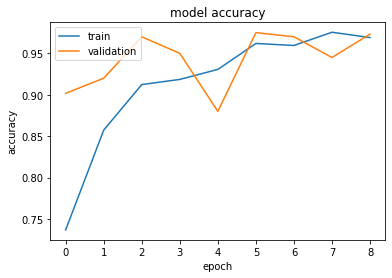

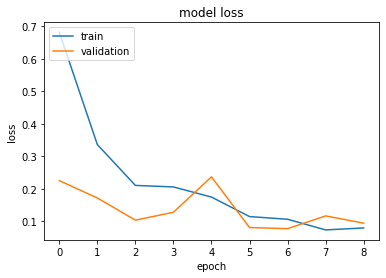

In [71]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

{0: 'modak', 1: 'not'}



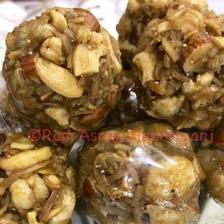

not


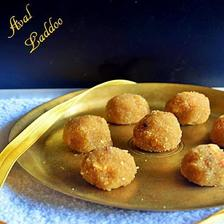

not


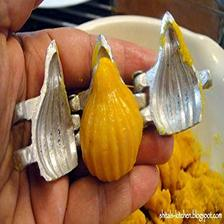

modak


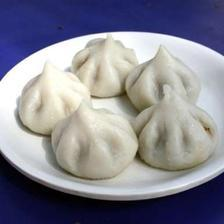

modak


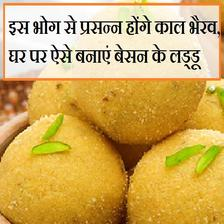

not


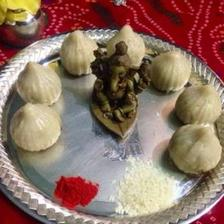

modak


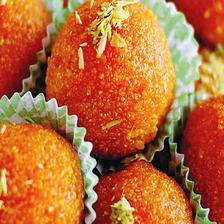

not


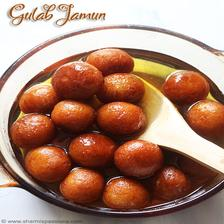

not


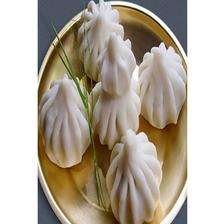

modak


In [72]:
test_files_path = '/content/drive/My Drive/modak/test/'
test_files = os.listdir(test_files_path)

label_map = (train_generator.class_indices) 
inv_map = {v: k for k, v in label_map.items()}

print(inv_map)
print()

width = 224
height = 224 

for file in test_files:
  img = plt.imread(os.path.join(test_files_path,file))
  pil_img = Image(os.path.join(test_files_path,file))
  display(pil_img)
  img = img.reshape(1,width,height,3)
  print(inv_map[model.predict_classes(img)[0][0]])